# <u>Churn Prediction</u>

## Problem
Can you predict whether a customer will churn or not?

## Problem Statement
Decreasing the Customer Churn is a key goal for any business. Predicting Customer Churn (also known as Customer Attrition) represents an additional potential revenue source for any business. Customer Churn impacts the cost to the business. Higher Customer Churn leads to loss in revenue and the additional marketing costs involved with replacing those customers with new ones. 

In this challenge, as a data scientist of a bank, you are asked to analyze the past data and predict whether the customer will churn or not in the next 6 months. This would help the bank to have the right engagement with customers at the right time.

## Objective
Our objective is to build a machine learning model to predict whether the customer will churn or not in the next six months.

## Data Dictionary

| Variable | Description |
| :- | :- |
| ID | Unique Identifier of a row |
| Age | Age of the customer |
| Gender | Gender of the customer (Male and Female) |
| Income | Yearly income of the customer |
| Balance | Average quarterly balance of the customer |
| Vintage | No. of years the customer is associated with bank |
| Transaction_Status | Whether the customer has done any transaction in the past 3 months or not |
| Product_Holdings | No. of product holdings with the bank |
| Credit_Card | Whether the customer has a credit card or not |
| Credit_Category | Category of a customer based on the credit score |
| Is_Churn *(target variable)* | Whether the customer will churn in next 6 months or not |


## Steps Performed
   1. Loading and Understanding the data
   1. Feature Engineering
   1. Model Building
   1. Model's Performance Comparison
   1. Conclusion
   1. Next Steps

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go
import warnings
warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,ID,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn
0,84e2fcc9,36,Female,5L - 10L,563266.44,4,0,1,0,Average,1
1,57fea15e,53,Female,Less than 5L,875572.11,2,1,1,1,Poor,0
2,8df34ef3,35,Female,More than 15L,701607.06,2,1,2,0,Poor,0
3,c5c0788b,43,Female,More than 15L,1393922.16,0,1,2,1,Poor,1
4,951d69c4,39,Female,More than 15L,893146.23,1,1,1,1,Good,1


In [4]:
sub_ids = test['ID']                              # storing sub_ids for submission
train.drop('ID', axis=1, inplace=True)
test.drop('ID', axis=1, inplace=True)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6650 entries, 0 to 6649
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 6650 non-null   int64  
 1   Gender              6650 non-null   object 
 2   Income              6650 non-null   object 
 3   Balance             6650 non-null   float64
 4   Vintage             6650 non-null   int64  
 5   Transaction_Status  6650 non-null   int64  
 6   Product_Holdings    6650 non-null   object 
 7   Credit_Card         6650 non-null   int64  
 8   Credit_Category     6650 non-null   object 
 9   Is_Churn            6650 non-null   int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 519.7+ KB


In [6]:
train.describe()

,Age,Balance,Vintage,Transaction_Status,Credit_Card,Is_Churn
count,6650.000000,6.650000e+03,6650.000000,6650.000000,6650.000000,6650.000000
mean,41.130226,8.045954e+05,2.250226,0.515789,0.664361,0.231128
std,9.685747,5.157549e+05,1.458795,0.499788,0.472249,0.421586
min,21.000000,6.300000e+01,0.000000,0.000000,0.000000,0.000000
25%,34.000000,3.922642e+05,1.000000,0.000000,0.000000,0.000000
50%,40.000000,7.649386e+05,2.000000,1.000000,1.000000,0.000000
75%,47.000000,1.147124e+06,3.000000,1.000000,1.000000,0.000000
max,72.000000,2.436616e+06,5.000000,1.000000,1.000000,1.000000


In [7]:
print('Train Shape: ', train.shape, '  Test Shape: ', test.shape)

Train Shape:  (6650, 10)   Test Shape:  (2851, 9)


### **From the above initial analysis it is clear that:**
   - There are 9 predictors out of which are 4 are categorical features and the rest are numericals
   - Train set has a total of 6650 records whereas there are 2851 in test set
   - There are no missing values in the datasets
   - Memory utilization by training dataset is minimal, around 520 KB
   - The statistical information tells the range and percecntile values of each numerical feature

In [8]:
num_features = [i for i in train.columns if train[i].dtype != 'object']            # list of numberical features
cat_features = [i for i in train.columns if train[i].dtype == 'object']            # list of cateforical features

## <u>Feature Engineering</u>

We have a good understanding of the data from the previous section. Here, we will alter the dataset to make it model ready. We are going to perform the following operations:
   1. Handle Missing Values
   1. Encode Categorical Features
   1. Feature Scaling
   1. Imbalanced Dataset 

In [9]:
# import libraries

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

### 1. Missing Values

In [10]:
train.isnull().sum()

Age                   0
Gender                0
Income                0
Balance               0
Vintage               0
Transaction_Status    0
Product_Holdings      0
Credit_Card           0
Credit_Category       0
Is_Churn              0
dtype: int64

In [11]:
test.isnull().sum()

Age                   0
Gender                0
Income                0
Balance               0
Vintage               0
Transaction_Status    0
Product_Holdings      0
Credit_Card           0
Credit_Category       0
dtype: int64

**We do not see any missing values in either of the datasets**

### 2. Encoding

Models understand only numbers. Hence, it is crucial to conver the categorical features to numerical values. There are multiple ways of achieving this. For example Label Encoding isused in case of ordinal values in categorical feature whereas One-Hot encoding can be used for nominal values. 

In [12]:
# Label Encoding Income and Credit Category
le_cols = ['Income', 'Credit_Category', 'Product_Holdings', 'Gender']
def LE(train, test):
    le = LabelEncoder()
    for col in le_cols:
            train[col] = le.fit_transform(train[col])
            test[col] = le.transform(test[col])
    return train, test

# train_en, test_en = LE(train, test)
LE(train, test)
train.head()

,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn
0,36,0,1,563266.44,4,0,0,0,0,1
1,53,0,2,875572.11,2,1,0,1,2,0
2,35,0,3,701607.06,2,1,1,0,2,0
3,43,0,3,1393922.16,0,1,1,1,2,1
4,39,0,3,893146.23,1,1,0,1,1,1


### 4. Scaling
Scaling is an important part of Feature Engineering. The idea behind scaling is to bring down all the values in a feature within a certain range. Here, we have used MinMax scaler on Vintage feature to squeeze all the values in the range of 0-1.

In [13]:
scaler = MinMaxScaler()
num_features = ['Age', 'Balance', 'Vintage']

train[num_features] = scaler.fit_transform(train[num_features])
test[num_features] = scaler.transform(test[num_features])

train.head()

,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn
0,0.294118,0,1,0.231148,0.8,0,0,0,0,1
1,0.627451,0,2,0.359323,0.4,1,0,1,2,0
2,0.274510,0,3,0.287925,0.4,1,1,0,2,0
3,0.431373,0,3,0.572062,0.0,1,1,1,2,1
4,0.352941,0,3,0.366536,0.2,1,0,1,1,1


### 5. Handling Imbalanced Class
In case of classification problems we should ensure the distribution of the classes in target feature. As the customers churned are quite less in number in the dataset, we need to adjust and balance the classes (churn vs not_churned). There are 2 techniques by which this can be achieved: Over-sampling and Under Sampling.

In [14]:
# X = train.drop('Is_Churn', axis=1)
# y = train['Is_Churn']

# sm = SMOTE(sampling_strategy = 'minority', k_neighbors = 1, random_state = 42)
# x_train_miss, y_train_miss = sm.fit_resample(X, y.ravel())

# x_train, x_test, y_train, y_test = train_test_split(x_train_miss, y_train_miss, test_size=0.3, random_state=42)

In [15]:
X = train.drop('Is_Churn', axis=1)
y = train['Is_Churn']

ad = ADASYN(sampling_strategy = 'minority', n_neighbors = 5, random_state = 140)
x_train_miss, y_train_miss = ad.fit_resample(X, y.ravel())

x_train, x_test, y_train, y_test = train_test_split(x_train_miss, y_train_miss, test_size=0.3, random_state=42)

## <u>Model Building</u>

In [18]:
# importing libraries for this section 

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
# import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
import keras
from keras.layers import Dense, Dropout 

In [19]:
def model_score_ann(model):
    ''' model score for ann. Converting the continuous variables to 0s and 1s'''
    yp = model.predict(x_test)
    y_pred = []
    for i in yp:
        if i<0.5:
            y_pred.append(0)
        else:
            y_pred.append(1)
        
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.set_context('talk')
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()

### ANN - with Dense

In [20]:
# Training a simple Artificial Neural Network
ann1 = keras.Sequential([
    keras.layers.Dense(2, input_dim=9, activation='leaky_relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [21]:
ann1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
history = ann1.fit(x_train, y_train, epochs = 100, validation_split=0.2, verbose=1, batch_size=100)

Epoch 1/100
56/56 [==============================] - 1s 7ms/step - loss: 1.0137 - accuracy: 0.4900 - val_loss: 0.9431 - val_accuracy: 0.4950
Epoch 2/100
56/56 [==============================] - 0s 2ms/step - loss: 0.8619 - accuracy: 0.4949 - val_loss: 0.8310 - val_accuracy: 0.5014
Epoch 3/100
56/56 [==============================] - 0s 2ms/step - loss: 0.7813 - accuracy: 0.4929 - val_loss: 0.7728 - val_accuracy: 0.4928
Epoch 4/100
56/56 [==============================] - 0s 2ms/step - loss: 0.7415 - accuracy: 0.4988 - val_loss: 0.7442 - val_accuracy: 0.4907
Epoch 5/100
56/56 [==============================] - 0s 2ms/step - loss: 0.7228 - accuracy: 0.4994 - val_loss: 0.7285 - val_accuracy: 0.4899
Epoch 6/100
56/56 [==============================] - 0s 2ms/step - loss: 0.7130 - accuracy: 0.5028 - val_loss: 0.7200 - val_accuracy: 0.5000
Epoch 7/100
56/56 [==============================] - 0s 2ms/step - loss: 0.7074 - accuracy: 0.5130 - val_loss: 0.7146 - val_accuracy: 0.4878
Epoch 8/100
5

Epoch 59/100
56/56 [==============================] - 0s 2ms/step - loss: 0.6657 - accuracy: 0.5937 - val_loss: 0.6720 - val_accuracy: 0.5819
Epoch 60/100
56/56 [==============================] - 0s 2ms/step - loss: 0.6647 - accuracy: 0.5948 - val_loss: 0.6710 - val_accuracy: 0.5819
Epoch 61/100
56/56 [==============================] - 0s 2ms/step - loss: 0.6642 - accuracy: 0.5992 - val_loss: 0.6707 - val_accuracy: 0.5884
Epoch 62/100
56/56 [==============================] - 0s 2ms/step - loss: 0.6635 - accuracy: 0.6019 - val_loss: 0.6699 - val_accuracy: 0.5905
Epoch 63/100
56/56 [==============================] - 0s 2ms/step - loss: 0.6627 - accuracy: 0.5998 - val_loss: 0.6687 - val_accuracy: 0.5934
Epoch 64/100
56/56 [==============================] - 0s 2ms/step - loss: 0.6621 - accuracy: 0.6009 - val_loss: 0.6680 - val_accuracy: 0.5934
Epoch 65/100
56/56 [==============================] - 0s 2ms/step - loss: 0.6621 - accuracy: 0.6009 - val_loss: 0.6682 - val_accuracy: 0.5934
Epoch 

              precision    recall  f1-score   support

           0       0.64      0.58      0.61      1541
           1       0.59      0.65      0.62      1442

    accuracy                           0.61      2983
   macro avg       0.62      0.62      0.61      2983
weighted avg       0.62      0.61      0.61      2983



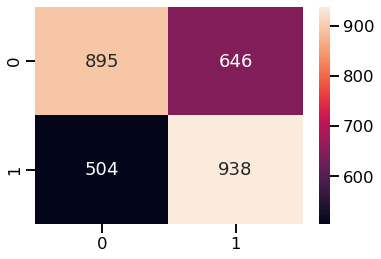

In [22]:
model_score_ann(ann1)

### ANN - with Dropout

In [23]:
ann2 = keras.Sequential()

ann2.add(Dense(250, input_dim=9, kernel_initializer = 'normal', activation = 'leaky_relu'))

ann2.add(Dropout(0.3))
ann2.add(Dense(500, activation = 'relu'))

ann2.add(Dense(2, activation = 'softmax'))
ann2.add(Dense(1, activation = 'sigmoid'))
ann2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 250)               2500      
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 dense_3 (Dense)             (None, 500)               125500    
                                                                 
 dense_4 (Dense)             (None, 2)                 1002      
                                                                 
 dense_5 (Dense)             (None, 1)                 3         
                                                                 
Total params: 129,005
Trainable params: 129,005
Non-trainable params: 0
_________________________________________________________________


In [24]:
ann2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
history = ann2.fit(x_train, y_train, epochs = 100, validation_split=0.2, verbose=1, batch_size=100)

Epoch 1/100
56/56 [==============================] - 1s 9ms/step - loss: 0.6951 - accuracy: 0.4891 - val_loss: 0.6932 - val_accuracy: 0.5431
Epoch 2/100
56/56 [==============================] - 0s 6ms/step - loss: 0.6906 - accuracy: 0.5380 - val_loss: 0.6874 - val_accuracy: 0.5524
Epoch 3/100
56/56 [==============================] - 0s 6ms/step - loss: 0.6861 - accuracy: 0.5716 - val_loss: 0.6871 - val_accuracy: 0.5510
Epoch 4/100
56/56 [==============================] - 0s 6ms/step - loss: 0.6810 - accuracy: 0.5836 - val_loss: 0.6783 - val_accuracy: 0.5841
Epoch 5/100
56/56 [==============================] - 0s 6ms/step - loss: 0.6765 - accuracy: 0.5922 - val_loss: 0.6740 - val_accuracy: 0.5999
Epoch 6/100
56/56 [==============================] - 0s 6ms/step - loss: 0.6718 - accuracy: 0.6041 - val_loss: 0.6717 - val_accuracy: 0.6056
Epoch 7/100
56/56 [==============================] - 0s 7ms/step - loss: 0.6699 - accuracy: 0.6045 - val_loss: 0.6708 - val_accuracy: 0.5970
Epoch 8/100
5

Epoch 59/100
56/56 [==============================] - 0s 6ms/step - loss: 0.6080 - accuracy: 0.6767 - val_loss: 0.6205 - val_accuracy: 0.6466
Epoch 60/100
56/56 [==============================] - 0s 6ms/step - loss: 0.5974 - accuracy: 0.6923 - val_loss: 0.6238 - val_accuracy: 0.6386
Epoch 61/100
56/56 [==============================] - 0s 6ms/step - loss: 0.6018 - accuracy: 0.6837 - val_loss: 0.6167 - val_accuracy: 0.6494
Epoch 62/100
56/56 [==============================] - 0s 6ms/step - loss: 0.5966 - accuracy: 0.6864 - val_loss: 0.6231 - val_accuracy: 0.6451
Epoch 63/100
56/56 [==============================] - 0s 6ms/step - loss: 0.5961 - accuracy: 0.6909 - val_loss: 0.6231 - val_accuracy: 0.6494
Epoch 64/100
56/56 [==============================] - 0s 6ms/step - loss: 0.5966 - accuracy: 0.6871 - val_loss: 0.6194 - val_accuracy: 0.6516
Epoch 65/100
56/56 [==============================] - 0s 6ms/step - loss: 0.5958 - accuracy: 0.6892 - val_loss: 0.6177 - val_accuracy: 0.6573
Epoch 

              precision    recall  f1-score   support

           0       0.72      0.59      0.65      1541
           1       0.63      0.75      0.69      1442

    accuracy                           0.67      2983
   macro avg       0.67      0.67      0.67      2983
weighted avg       0.68      0.67      0.67      2983



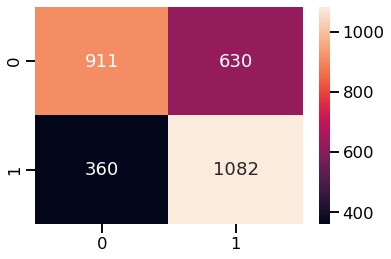

In [25]:
model_score_ann(ann2)

### ANN - with Optimization

In [26]:
import keras_tuner as kt

In [27]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, test_size=0.2, random_state = 42)

In [28]:
BATCH_SIZE=32

def create_model(hp):
    model = keras.Sequential()
    
    for i in range(hp.Choice('hidden_layers', values=[1])):
        model.add(keras.layers.Dense(units = hp.Int("units_{}".format(i+1),min_value=2,max_value=40,step=1), activation='relu')),
        model.add(keras.layers.Dropout(hp.Choice("dropout_{}".format(i+1), values=[0.3, 0.4, 0.5]))),

    model.add(keras.layers.Dense(1, activation='sigmoid')),
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam' ,
                  metrics=['accuracy'])
    
    return model

In [29]:
tuner_bo = kt.BayesianOptimization(
        create_model,
        objective="val_accuracy",
        max_trials=100,
        seed=42,
        directory='my_dir',
        project_name='kt',
        overwrite=True)

In [30]:
early_stop = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

In [31]:
tuner_bo.search(x_train, y_train,validation_data=(x_val, y_val), callbacks=[early_stop])

Trial 100 Complete [00h 00m 01s]
val_accuracy: 0.5747126340866089

Best val_accuracy So Far: 0.5883620977401733
Total elapsed time: 00h 04m 30s
INFO:tensorflow:Oracle triggered exit


In [32]:
tuner_bo.results_summary(num_trials=1)

Results summary
Results in my_dir\kt
Showing 1 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
hidden_layers: 1
units_1: 40
dropout_1: 0.4
Score: 0.5883620977401733


In [33]:
best_hps_bo=tuner_bo.get_best_hyperparameters()[0]

In [34]:
hypermodel_bo = tuner_bo.hypermodel.build(best_hps_bo)

In [35]:
history = hypermodel_bo.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[early_stop])

Epoch 1/100
174/174 [==============================] - 1s 3ms/step - loss: 0.7257 - accuracy: 0.5055 - val_loss: 0.6864 - val_accuracy: 0.5409
Epoch 2/100
174/174 [==============================] - 0s 2ms/step - loss: 0.6942 - accuracy: 0.5324 - val_loss: 0.6796 - val_accuracy: 0.5711
Epoch 3/100
174/174 [==============================] - 0s 2ms/step - loss: 0.6862 - accuracy: 0.5472 - val_loss: 0.6773 - val_accuracy: 0.5790
Epoch 4/100
174/174 [==============================] - 0s 2ms/step - loss: 0.6838 - accuracy: 0.5493 - val_loss: 0.6745 - val_accuracy: 0.5912
Epoch 5/100
174/174 [==============================] - 0s 2ms/step - loss: 0.6794 - accuracy: 0.5651 - val_loss: 0.6721 - val_accuracy: 0.5991
Epoch 6/100
174/174 [==============================] - 0s 2ms/step - loss: 0.6740 - accuracy: 0.5795 - val_loss: 0.6714 - val_accuracy: 0.5862
Epoch 7/100
174/174 [==============================] - 0s 2ms/step - loss: 0.6753 - accuracy: 0.5779 - val_loss: 0.6689 - val_accuracy: 0.6085

In [36]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 28


In [37]:
hypermodel_bo = tuner_bo.hypermodel.build(best_hps_bo)

In [38]:
history = hypermodel_bo.fit(x_train, y_train, epochs=best_epoch, validation_data=(x_val, y_val), callbacks=[early_stop])

Epoch 1/28
174/174 [==============================] - 1s 3ms/step - loss: 0.7034 - accuracy: 0.5066 - val_loss: 0.6838 - val_accuracy: 0.5596
Epoch 2/28
174/174 [==============================] - 0s 2ms/step - loss: 0.6874 - accuracy: 0.5409 - val_loss: 0.6793 - val_accuracy: 0.5812
Epoch 3/28
174/174 [==============================] - 0s 2ms/step - loss: 0.6856 - accuracy: 0.5507 - val_loss: 0.6752 - val_accuracy: 0.5905
Epoch 4/28
174/174 [==============================] - 0s 2ms/step - loss: 0.6787 - accuracy: 0.5701 - val_loss: 0.6719 - val_accuracy: 0.5934
Epoch 5/28
174/174 [==============================] - 0s 2ms/step - loss: 0.6768 - accuracy: 0.5730 - val_loss: 0.6689 - val_accuracy: 0.5991
Epoch 6/28
174/174 [==============================] - 0s 2ms/step - loss: 0.6759 - accuracy: 0.5750 - val_loss: 0.6664 - val_accuracy: 0.6020
Epoch 7/28
174/174 [==============================] - 0s 2ms/step - loss: 0.6704 - accuracy: 0.5800 - val_loss: 0.6635 - val_accuracy: 0.6164
Epoch 

              precision    recall  f1-score   support

           0       0.64      0.62      0.63      1541
           1       0.61      0.62      0.61      1442

    accuracy                           0.62      2983
   macro avg       0.62      0.62      0.62      2983
weighted avg       0.62      0.62      0.62      2983



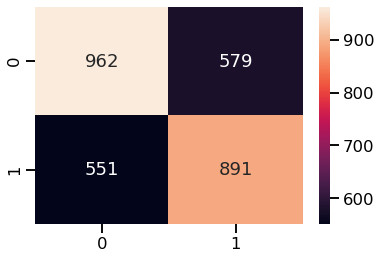

In [39]:
model_score_ann(hypermodel_bo)

## <u>Model Comparison</u>

In [40]:
# calculating the false positive and true positive rate for each of the models
fpr1, tpr1, thresh1 = roc_curve(y_test, ann1.predict(x_test), pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, ann2.predict(x_test), pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, hypermodel_bo.predict(x_test), pos_label=1)

In [41]:
# Fething the Area under the curve 

auc_score1 = roc_auc_score(y_test, ann1.predict(x_test))
auc_score2 = roc_auc_score(y_test, ann2.predict(x_test))
auc_score3 = roc_auc_score(y_test, hypermodel_bo.predict(x_test))

print("Artificial Neural Network with Dense Layers: ", auc_score1)
print("Artificial Neural Network with Dense and Dropout: ", auc_score2)
print("Artificial Neural Network with Hyperparameter Tuning: ", auc_score3)

Artificial Neural Network with Dense Layers:  0.6745439719331342
Artificial Neural Network with Dense and Dropout:  0.7077637951471611
Artificial Neural Network with Hyperparameter Tuning:  0.677846670884857


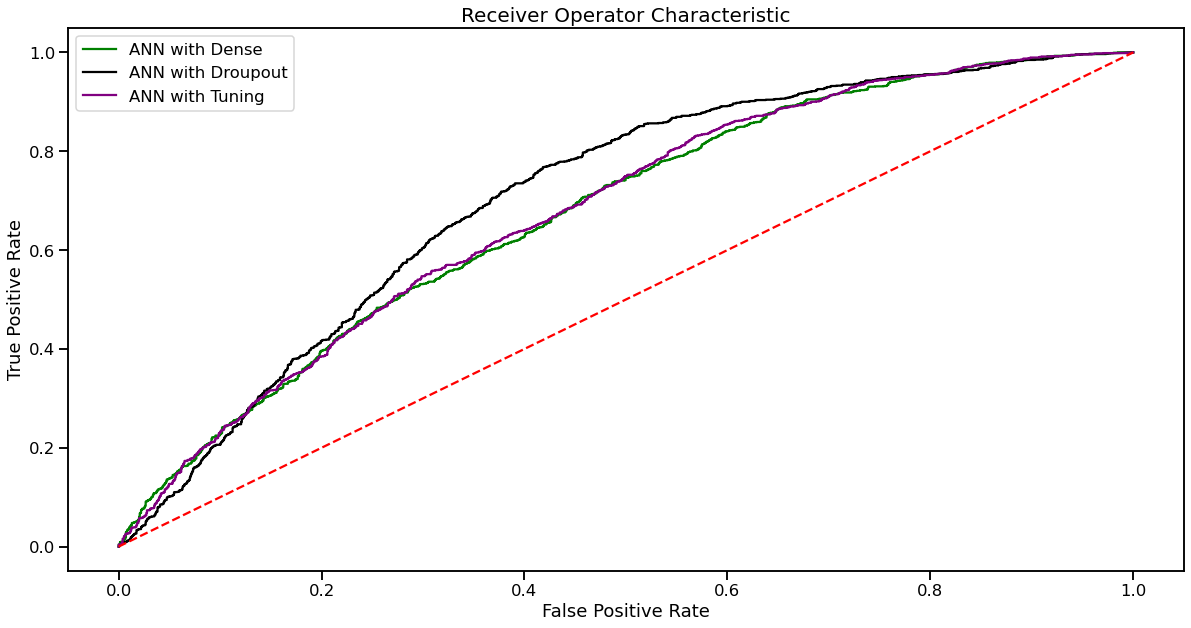

In [42]:
# Plotting ROC curve
plt.figure(figsize=(20,10))
plt.plot(fpr1, tpr1, color = 'green', label='ANN with Dense')
plt.plot(fpr2, tpr2, color = 'black', label='ANN with Droupout')
plt.plot(fpr3, tpr3, color = 'purple', label='ANN with Tuning')
         
plt.title('Receiver Operator Characteristic', fontsize=20)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1],'r--') 
plt.legend(loc = 'best')
plt.show()

**Model Comparison Results:**
- ROC-AUC curve shows the model performance by plotting the false positive rate to true positive rate
- More the skewness of the curve towards the upper left corner higher is the area under the roc curve and better is the model performance
- From the ROC-AUC curve it is clear that ANN with droupout performed the best followed by tuned ANN and ANN with dense layer.

## <u>Summary</u>

In this classification problem the dataset given was quite clean, it had no missing values and a lot of information regarding the customers' was provided.
<p>
It was a binary classification problem with only 2 classes in the target feature (0: not churned, 1: churned). The classes were imbalanced and the models were predicting all 0s in the target feature. To resolve this we had used over-sampling technique. 
<p>
We used different encoding techniques depending on the feature type. We used Label Encoder for ordinal values whereas one hot encoding for the nominal ones. The Age and Balance features were binned and encoded later on.

<b>One important takeaway is new customers are more likely to churn and also customers with high income are hard to retain. The Bank can focus on these 2 groups to bring down the churn rate.

## <u>Next Steps</u>

To improve the model performance and to get higher accuracy the below things can be done:
   - A model's performance increases with increase in data (clean and relevant). If we can feed in more data we can achieve higher accuracy.
   - We can try extracting features like (Product_Holdings - Credit_Card) assuming credit card as one of the products we can fetch how many other products the customer is holding.
   - Experimenting with under-sampling to see whether there is any change in model performance
   - Trying other tuning methods like Optuna or Hyperband or Random Search Optimizer